<a href="https://colab.research.google.com/github/richardogoma/health-clinic-data-summary-richardogoma/blob/main/Health_Data_Summary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mini Project: Health Clinic Data Summary & Outlier Analysis**

LifeCare Clinics, a rapidly growing healthcare provider collects patient vital signs (heart rate, blood pressure, etc.) daily. However, the data is currently stored in raw CSV files, and the doctors are struggling to identify patients who are at “high risk” (outliers) manually.

**The goal of this project is to build a data analysis pipeline** to ingest the raw data, clean it, calculate statistical summaries for the doctors, and automatically flag patients with irregular vitals (outliers) for immediate medical review.

## Module 1: Data Ingestion & Cleaning

In [1]:
import csv

def load_data(filepath: str) -> list[dict]:
    """
    Loads patient vital signs data from a CSV file.

    Args:
        filepath (str): The path to the CSV file.

    Returns:
        list[dict]: A list of dictionaries, where each dictionary represents one patient.
                    Returns an empty list if an error occurs.
    """
    patient_data = []
    try:
        with open(filepath, mode='r', newline='', encoding='utf-8') as file:
            reader = csv.DictReader(file)
            for row in reader:
                processed_row = {}
                for key, value in row.items():
                    try:
                        if key in ['patient_id', 'age', 'heart_rate', 'systolic_bp', 'oxygen_saturation']:
                            processed_row[key] = int(value)
                        elif key in ['temperature']:
                            processed_row[key] = float(value)
                    except ValueError:
                        print(f"Warning: Could not convert '{value}' for column '{key}' to a numeric type in row: {row}")
                        processed_row[key] = None
                patient_data.append(processed_row)
        print(f"Successfully loaded data from {filepath}.")
    except FileNotFoundError:
        print(f"Error: The file '{filepath}' was not found.")

    return patient_data


## Module 2: The Analytics Engine

### Arithmetic Mean

In [2]:
def calculate_mean(values: list[float | int]) -> float | None:
    """
    Calculates the arithmetic mean of a list of numeric values.

    Args:
        values (list[float | int]): A list of numbers.

    Returns:
        float | None: The arithmetic mean of the values, or None if the list is empty.
    """
    numeric_values = [v for v in values if v is not None]
    if not numeric_values:
        return None
    return sum(numeric_values) / len(numeric_values)


### Median

In [3]:
def calculate_median(values: list[float | int]) -> float | None:
    """
    Calculates the median of a list of numeric values.

    Args:
        values (list[float | int]): A list of numbers.

    Returns:
        float | None: The median of the values, or None if the list is empty.
    """
    numeric_values = sorted([v for v in values if v is not None])
    n = len(numeric_values)

    if n == 0:
        return None
    elif n % 2 == 1:
        return float(numeric_values[n // 2])
    else:
        mid1 = numeric_values[n // 2 - 1]
        mid2 = numeric_values[n // 2]
        return (float(mid1) + float(mid2)) / 2


### Mode

In [4]:
from collections import Counter

def calculate_mode(values: list[float | int]) -> list[float | int] | None:
    """
    Calculates the mode(s) of a list of numeric values.

    Args:
        values (list[float | int]): A list of numbers.

    Returns:
        list[float | int] | None: A list of the most frequent value(s), or None if the list is empty.
    """
    numeric_values = [v for v in values if v is not None]

    if not numeric_values:
        return None

    counts = Counter(numeric_values)

    max_frequency = 0
    if counts:
        max_frequency = max(counts.values())

    modes = [key for key, value in counts.items() if value == max_frequency]

    return sorted(modes)


### Severity Levels: IQR (Interquartile Range) Method

In [5]:
def calculate_outliers(values: list[float | int]) -> list[float | int]:
    """
    Calculates outliers using the Interquartile Range (IQR) method.

    Args:
        values (list[float | int]): A list of numeric values.

    Returns:
        list[float | int]: A list of values identified as outliers.
    """
    numeric_values = sorted([v for v in values if v is not None])
    n = len(numeric_values)

    if n < 2: # At least two values are needed to define a range, though more for robust quartiles
        return []

    # Calculate Q1 (median of the first half of the data)
    q1_data = numeric_values[0 : n // 2]
    q1 = calculate_median(q1_data)

    # Calculate Q3 (median of the second half of the data)
    # If n is odd, the overall median element is typically excluded from both halves
    # for Q1 and Q3 calculation using this method.
    q3_start_index = (n // 2) + (n % 2)
    q3_data = numeric_values[q3_start_index : n]
    q3 = calculate_median(q3_data)

    # If Q1 or Q3 could not be calculated (e.g., too few elements in halves),
    # return an empty list of outliers.
    if q1 is None or q3 is None:
        return []

    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)

    outliers = []
    for value in numeric_values:
        if value < lower_bound or value > upper_bound:
            outliers.append(value)

    return outliers


In [6]:
def calculate_categorized_outliers(values: list[float | int]) -> list[tuple[float | int, str]]:
    """
    Calculates and categorizes outliers using the Interquartile Range (IQR) method
    into 'High Risk' and 'Critical' levels.

    Args:
        values (list[float | int]): A list of numeric values.

    Returns:
        list[tuple[float | int, str]]: A list of tuples, where each tuple contains
                                        an outlier value and its risk level ('High Risk' or 'Critical').
    """
    numeric_values = sorted([v for v in values if v is not None])
    n = len(numeric_values)

    if n < 2:
        return []

    # Calculate Q1 (median of the first half of the data)
    q1_data = numeric_values[0 : n // 2]
    q1 = calculate_median(q1_data)

    # Calculate Q3 (median of the second half of the data)
    q3_start_index = (n // 2) + (n % 2)
    q3_data = numeric_values[q3_start_index : n]
    q3 = calculate_median(q3_data)

    if q1 is None or q3 is None:
        return []

    iqr = q3 - q1

    # Define bounds for 'High Risk' (mild outliers) and 'Critical' (extreme outliers)
    # Mild outliers are beyond 1.5 * IQR from Q1/Q3
    mild_lower_bound = q1 - (1.5 * iqr)
    mild_upper_bound = q3 + (1.5 * iqr)

    # Critical outliers are beyond 3 * IQR from Q1/Q3
    extreme_lower_bound = q1 - (3 * iqr)
    extreme_upper_bound = q3 + (3 * iqr)

    categorized_outliers = []
    for value in numeric_values:
        if value < extreme_lower_bound or value > extreme_upper_bound:
            categorized_outliers.append((value, 'Critical'))
        elif value < mild_lower_bound or value > mild_upper_bound:
            categorized_outliers.append((value, 'High Risk'))

    return categorized_outliers


## Module 3: Reporting
* This function orchestrates the flow: it calls your loader, runs the stats functions on specific vitals (Heart Rate and Temperature), and prints a clean report.
* It should identify the patient_id of anyone flagged as an outlier.

In [7]:
def generate_summary_report(filepath: str):
    """
    Generates a summary report of patient vital signs, including statistical summaries
    and outlier identification for Heart Rate and Temperature.

    Args:
        filepath (str): The path to the CSV file containing patient vital signs.
    """
    print("\n--- Generating Health Clinic Data Summary Report ---\n")

    # Load Data
    patient_data = load_data(filepath)
    if not patient_data:
        print("No data loaded. Report cannot be generated.")
        return

    print(f"Total records loaded: {len(patient_data)}\n")

    # Prepare data for analysis
    heart_rates = [p['heart_rate'] for p in patient_data if p and 'heart_rate' in p and p['heart_rate'] is not None]
    temperatures = [p['temperature'] for p in patient_data if p and 'temperature' in p and p['temperature'] is not None]

    vitals_to_analyze = {
        'Heart Rate': heart_rates,
        'Temperature': temperatures
    }

    for vital_name, values in vitals_to_analyze.items():
        print(f"--- {vital_name} Analysis ---")
        mean_val = calculate_mean(values)
        median_val = calculate_median(values)
        mode_val = calculate_mode(values)
        outliers_list = calculate_categorized_outliers(values)

        print(f"  Mean: {mean_val:.2f}" if mean_val is not None else "  Mean: N/A")
        print(f"  Median: {median_val:.2f}" if median_val is not None else "  Median: N/A")
        print(f"  Mode: {', '.join(map(str, mode_val))}" if mode_val else "  Mode: N/A")

        if outliers_list:
            combined_outliers_info = []
            # Iterate through each patient to see if their vital value is an outlier
            for patient in patient_data:
                patient_id = patient.get('patient_id')
                patient_vital_value = patient.get(vital_name.lower().replace(' ', '_'))

                if patient_id is not None and patient_vital_value is not None:
                    # Check if this patient's vital value matches any of the detected numerical outlier values
                    for outlier_val, severity_level in outliers_list:
                        if patient_vital_value == outlier_val:
                            # Add (patient_id, outlier_value, severity_level) to our combined list
                            combined_outliers_info.append((patient_id, outlier_val, severity_level))
                            break

            if combined_outliers_info:
                # Sort for consistent output. Using a set of tuples to ensure uniqueness of (patient_id, value, severity)
                unique_combined_outliers = sorted(list(set(combined_outliers_info)))

                # Format the output for readability
                formatted_outliers = [
                    f"Patient ID: {pid}, Value: {val}, Severity: {sev}"
                    for pid, val, sev in unique_combined_outliers
                ]
                print(f"  Outliers identified ({len(unique_combined_outliers)}):")
                for item in formatted_outliers:
                    print(f"    - {item}")
            else:
                print(f"  No specific patient IDs found for {vital_name} outliers.")
        else:
            print("  No outliers detected.")
        print()

    print("--- Report Generation Complete ---")

generate_summary_report('/data/patient_vitals_outliers.csv')



--- Generating Health Clinic Data Summary Report ---

Successfully loaded data from /data/patient_vitals_outliers.csv.
Total records loaded: 102

--- Heart Rate Analysis ---
  Mean: 160.08
  Median: 81.00
  Mode: 67, 74, 78, 93
  Outliers identified (2):
    - Patient ID: 1, Value: 7700, Severity: Critical
    - Patient ID: 3, Value: 350, Severity: Critical

--- Temperature Analysis ---
  Mean: 36.20
  Median: 36.35
  Mode: 35.5, 36.6
  No outliers detected.

--- Report Generation Complete ---


### Distribution of Patient Heart Rates

Successfully loaded data from /data/patient_vitals.csv.


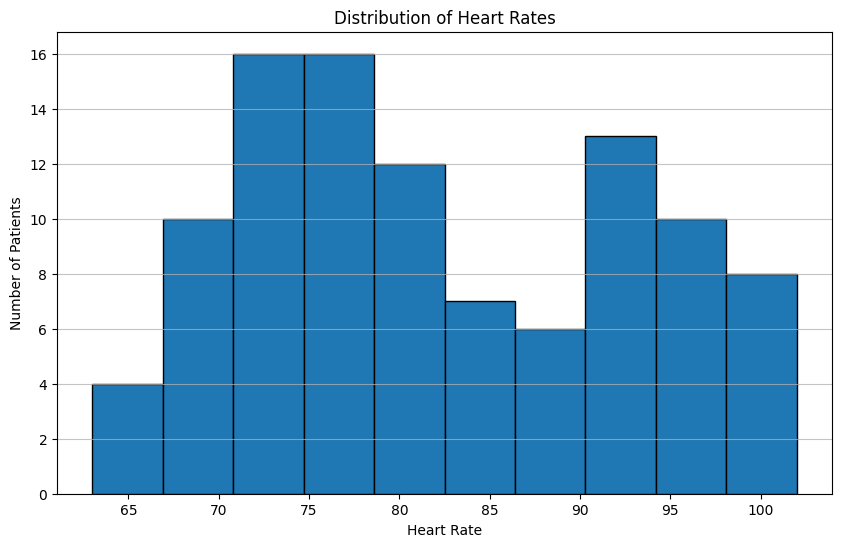

In [8]:
import matplotlib.pyplot as plt

# Reload data to ensure it's accessible for plotting, using the file with outliers
patient_data_for_plot = load_data('/data/patient_vitals.csv')

if patient_data_for_plot:
    heart_rates_for_plot = [p['heart_rate'] for p in patient_data_for_plot if p and 'heart_rate' in p and p['heart_rate'] is not None]

    if heart_rates_for_plot:
        plt.figure(figsize=(10, 6))
        plt.hist(heart_rates_for_plot, bins=10, edgecolor='black') # Adjust bins as needed
        plt.title('Distribution of Heart Rates')
        plt.xlabel('Heart Rate')
        plt.ylabel('Number of Patients')
        plt.grid(axis='y', alpha=0.75)
        plt.show()
    else:
        print("No valid heart rate data available for plotting.")
else:
    print("Could not load patient data for plotting.")